# Creating vector representations of SEU Neuron Morphologies

In [423]:
import getpass

import numpy as np
import pandas as pd

from kgforge.core import KnowledgeGraphForge

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from bluegraph import PandasPGFrame
from bluegraph.preprocess import ScikitLearnPGEncoder
from bluegraph.downstream.utils import transform_to_2d, plot_2d
from bluegraph.preprocess import CooccurrenceGenerator
from bluegraph.backends.stellargraph import StellarGraphNodeEmbedder
from bluegraph.backends.networkx import NXCommunityDetector

In [250]:
def get_encoder_features(prop_name, encoder, last_index):
    if encoder is None or isinstance(encoder, StandardScaler):
        return {last_index: f"{prop_name}_IDENTITY"}, last_index + 1
    if isinstance(encoder, TfidfVectorizer):
        return (
            {
                i + last_index: f"{prop_name}_WORD_{f}"
                for i, f in enumerate(encoder.get_feature_names())
            },
            last_index + len(encoder.get_feature_names())
        )
    elif isinstance(encoder, MultiLabelBinarizer):
        return (
            {
                i + last_index: f"{prop_name}_CLASS_{c}"
                for i, c in enumerate(encoder.classes_)
            },
            last_index + len(encoder.classes_)
        )
    
    else:
        return {}, last_index

def explain_property_coordinates(encoder, graph):
    last_index = 0
    property_coordinates = {}
    for p in graph.node_properties():
        if p in encoder._node_encoders:
            res, new_index = get_encoder_features(
                p, encoder._node_encoders[p], last_index)
            property_coordinates.update(res)
            last_index = new_index
    return property_coordinates

## Load morphologies from Nexus

In [2]:
TOKEN = getpass.getpass()

········


In [194]:
forge = KnowledgeGraphForge("../BlueGraphExperiments/config/new-forge-config.yaml",
                            token=TOKEN,
                            bucket="bbp-external/seu")

In [195]:
morphologies = forge.search({"type": "NeuronMorphology"}, limit=None)

In [267]:
morphologies_df = forge.as_dataframe(morphologies)[[
    "id",
    "brainLocation.brainRegion.id",
    "brainLocation.coordinatesInBrainAtlas.valueX.value",
    "brainLocation.coordinatesInBrainAtlas.valueY.value",
    "brainLocation.coordinatesInBrainAtlas.valueZ.value",
    "somaNumberOfPoints.value",
    "neuriteFeature",
    "subject.name"
]]

In [200]:
forge = KnowledgeGraphForge(
    "../BlueGraphExperiments/config/new-forge-config.yaml",
    token=TOKEN,
    bucket="neurosciencegraph/datamodels")

In [202]:
brain_region_resources = [
    forge.retrieve(el) for el in morphologies_df["brainLocation.brainRegion.id"]
]

In [264]:
brain_region_notation = {
    r.id: (r.notation, r.prefLabel)
    for r in brain_region_resources
}

In [270]:
def get_notation(region_id):
    if region_id not in brain_region_notation:
        r = forge.retrieve(region_id)
        brain_region_notation[r.id] = (r.notation, r.prefLabel)
    return brain_region_notation[region_id][0]

In [271]:
def get_neurite_features(data):
    
    result = {
        "has_Axon_feature": 0,
        "has_BasalDendrite_feature": 0,
        "has_ApicalDendrite_feature": 0
    }
    
    def _process_data(el, prefix):
        result[f"{prefix}_cumulatedLength"] = el["cumulatedLength"]["value"]
        result[f"{prefix}_longestBranchLength"] = el["longestBranchLength"]["value"]
        result[f"{prefix}_longestBranchNumberOfNodes"] = el["longestBranchNumberOfNodes"]
        result[f"{prefix}_numberOfProjections"] = el["numberOfProjections"]
        result[f"{prefix}_projectionBrainRegion"] = {
            get_notation(r["id"]) for r in el["projectionBrainRegion"]
        } if isinstance(el["projectionBrainRegion"], list) else {get_notation(el["projectionBrainRegion"]["id"])}
        result[f"{prefix}_traversedBrainRegion"] = {
            get_notation(r["id"]) for r in el["traversedBrainRegion"]
        } if isinstance(el["traversedBrainRegion"], list) else {get_notation(el["traversedBrainRegion"]["id"])}

    for el in data:
        result["has_" + el["type"] + "_feature"] = 1
        _process_data(el, el["type"])

    return result

In [272]:
neurite_features = morphologies_df["neuriteFeature"].apply(get_neurite_features).tolist()

In [273]:
neurite_feature_df = pd.DataFrame(neurite_features)

In [274]:
morphologies_df["brainLocation.brainRegion.id"] = morphologies_df["brainLocation.brainRegion.id"].apply(
    lambda x: brain_region_notation[x][0])

## Create a property graph (only nodes)

In [275]:
nodes = pd.concat(
    [morphologies_df, neurite_feature_df], axis=1).drop(
        columns=["neuriteFeature"]).rename(columns={"id": "@id"}).set_index("@id")

In [276]:
frame = PandasPGFrame()

In [277]:
frame._nodes = nodes

In [278]:
categorical_props = [
    "brainLocation.brainRegion.id",
    "subject.name",
    "has_Axon_feature",
    "has_BasalDendrite_feature",
    "has_ApicalDendrite_feature",
    "BasalDendrite_projectionBrainRegion",
    "BasalDendrite_traversedBrainRegion",
    "ApicalDendrite_projectionBrainRegion",
    "ApicalDendrite_traversedBrainRegion",
    "Axon_projectionBrainRegion",
    "Axon_traversedBrainRegion",
]

In [279]:
for column in nodes.columns:
    if column != "@type":
        if column not in categorical_props:
            frame.node_prop_as_numeric(column)
        else:
            frame.node_prop_as_category(column)

In [280]:
frame.rename_node_properties({
    p: p.replace(".", "_")
    for p in frame.node_properties()
})

In [281]:
encoder = ScikitLearnPGEncoder(
    node_properties=frame.node_properties(),
    missing_numeric="impute",
    imputation_strategy="mean")

In [282]:
encoded_frame = encoder.fit_transform(frame)

Dimensionality of vectors

In [283]:
encoded_frame._nodes["features"].iloc[0].shape

(781,)

Let's plot a 2D projection of what we have got

In [284]:
X = np.array(encoded_frame._nodes["features"].apply(lambda x: x.tolist()).tolist())
features_2d = transform_to_2d(X)

In [285]:
frame.add_node_properties(
    encoded_frame._nodes["features"])

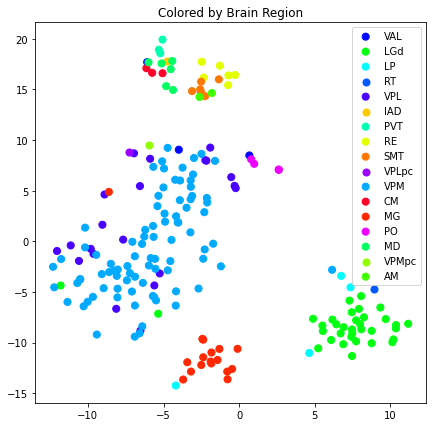

In [288]:
plot_2d(
    frame, vectors=features_2d, label_prop="brainLocation_brainRegion_id",
    title="Colored by Brain Region")

### (Optional) remove features of low variance

Try more from here: https://scikit-learn.org/stable/modules/feature_selection.html

In [380]:
sel = VarianceThreshold(threshold=0.5)
reduced = sel.fit_transform(X)
reduced_features_2d = transform_to_2d(reduced)

In [381]:
print("Original shape: ", X.shape)
print("Reduced shape: ", reduced.shape)

Original shape:  (200, 781)
Reduced shape:  (200, 12)


In [382]:
selected_indices = [i for i, el in enumerate(sel.get_support().tolist()) if el is True]
coord = explain_property_coordinates(encoder, frame)
included_props_features = [coord[i] for i in selected_indices]

In [383]:
included_props_features

['brainLocation_coordinatesInBrainAtlas_valueX_value_IDENTITY',
 'brainLocation_coordinatesInBrainAtlas_valueY_value_IDENTITY',
 'brainLocation_coordinatesInBrainAtlas_valueZ_value_IDENTITY',
 'somaNumberOfPoints_value_IDENTITY',
 'BasalDendrite_cumulatedLength_IDENTITY',
 'BasalDendrite_longestBranchLength_IDENTITY',
 'BasalDendrite_longestBranchNumberOfNodes_IDENTITY',
 'BasalDendrite_numberOfProjections_IDENTITY',
 'Axon_cumulatedLength_IDENTITY',
 'Axon_longestBranchLength_IDENTITY',
 'Axon_longestBranchNumberOfNodes_IDENTITY',
 'Axon_numberOfProjections_IDENTITY']

### (Optional) reduce dimensionality


In [353]:
pca_encoder = PCA(n_components=64)

In [354]:
X_embedded = pca_encoder.fit_transform(X)

In [355]:
frame._nodes["reduced_features"] = X_embedded.tolist()

Explained variance of data

In [356]:
sum(pca_encoder.explained_variance_ratio_)

0.8951028373574716

## Create axon co-projection edges and use graph embedding

In [391]:
gen = CooccurrenceGenerator(frame)
edges = gen.generate_from_nodes(
    "Axon_projectionBrainRegion",
    compute_statistics=["frequency"])

In [408]:
edges = edges[edges["frequency"] > 3]

In [409]:
frame._edges = edges
frame.edge_prop_as_numeric("frequency")

In [411]:
node2vec_embedder = StellarGraphNodeEmbedder(
    "node2vec", edge_weight="frequency",
    embedding_dimension=128, length=10, number_of_walks=20)
node2vec_embedding = node2vec_embedder.fit_model(frame)

In [412]:
attri2vec_embedder = StellarGraphNodeEmbedder(
    "attri2vec", feature_vector_prop="reduced_features",
    length=5, number_of_walks=10,
    epochs=10, embedding_dimension=128, edge_weight="frequency")
attri2vec_embedding = attri2vec_embedder.fit_model(frame)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [413]:
frame.add_node_properties(
    node2vec_embedding.rename(columns={"embedding": "node2vec"}))

In [414]:
frame.add_node_properties(
    attri2vec_embedding.rename(columns={"embedding": "attri2vec"}))

In [415]:
node2vec_2d = transform_to_2d(frame._nodes["node2vec"].tolist())
attri2vec_2d = transform_to_2d(frame._nodes["attri2vec"].tolist())

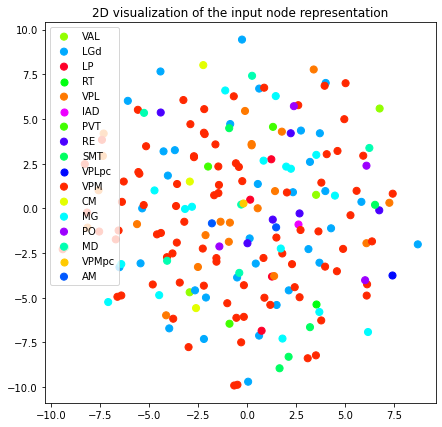

In [416]:
plot_2d(frame, vectors=node2vec_2d, label_prop="brainLocation_brainRegion_id")

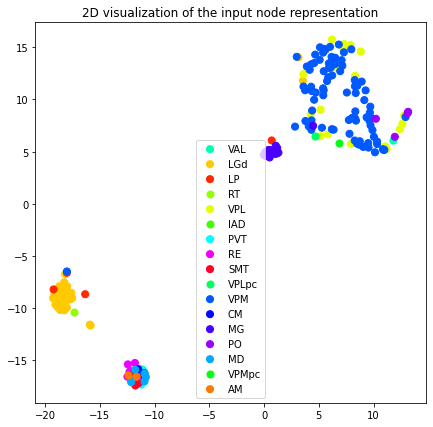

In [438]:
plot_2d(frame, vectors=attri2vec_2d, label_prop="brainLocation_brainRegion_id")

In [430]:
det = NXCommunityDetector(frame, directed=False)

In [435]:
det.detect_communities(
    strategy='louvain', weight="frequency", write=True, write_property="community")

In [437]:
frame.export_to_gephi(
    "seu_morphologies_co_proj",
    node_attr_mapping={
        "brainLocation_brainRegion_id": "Region"
    },
    edge_attr_mapping={
        "frequency": "weight"
    })

<img src="figures/neu_co_proj_illustration.png">